In [19]:
import numpy as np
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.api.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.api.models import Sequential
from keras.api.applications import VGG16
from keras.api.optimizers import Adam
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define new dataset path
train_dir = r"D:\sdp\redd\train"
test_dir = r"D:\sdp\redd\test"

In [20]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Load Training & Testing Data
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 15000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [21]:
# Load Pretrained VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model

# Define Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,299 (56.76 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
import pickle
import tensorflow as tf

epochs = 5
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=epochs,
    verbose=2
)
model.save("my_model.h5")
with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("Model and training history saved successfully!")


Epoch 1/5
469/469 - 441s - 940ms/step - accuracy: 0.6169 - loss: 0.7919 - val_accuracy: 0.7977 - val_loss: 0.4648
Epoch 2/5
469/469 - 416s - 887ms/step - accuracy: 0.7601 - loss: 0.5396 - val_accuracy: 0.8557 - val_loss: 0.3522
Epoch 3/5
469/469 - 418s - 891ms/step - accuracy: 0.7940 - loss: 0.4681 - val_accuracy: 0.8713 - val_loss: 0.3082
Epoch 4/5
469/469 - 432s - 921ms/step - accuracy: 0.8116 - loss: 0.4372 - val_accuracy: 0.8737 - val_loss: 0.2970
Epoch 5/5
469/469 - 393s - 838ms/step - accuracy: 0.8212 - loss: 0.4176 - val_accuracy: 0.8870 - val_loss: 0.2719


Model and training history saved successfully!


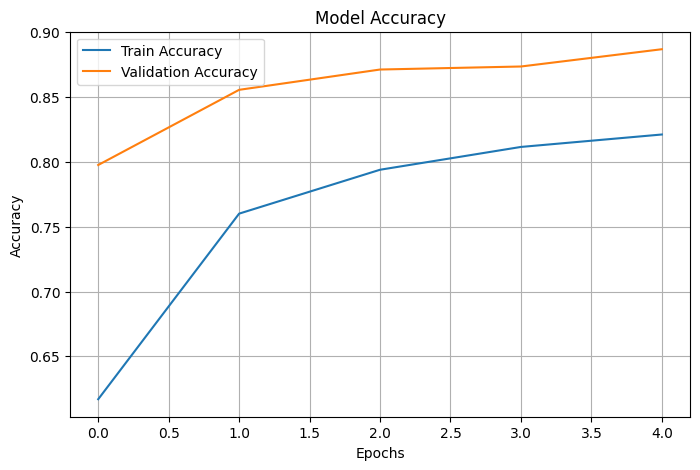

In [25]:

def plot_accuracy(history):
    plt.figure(figsize=(8, 5))  # Set figure size
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()
    plt.show(block=True)  # Force displayy

plot_accuracy(history)

In [20]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


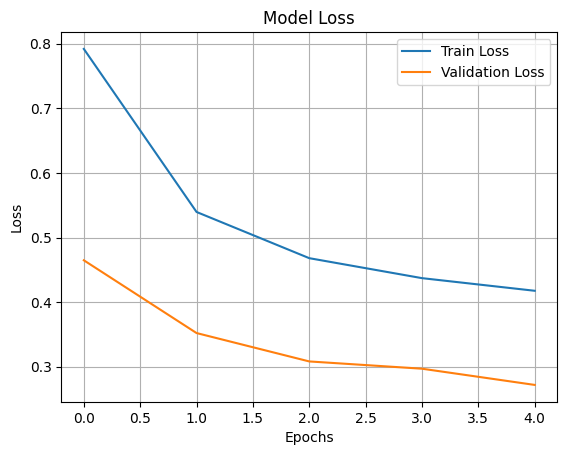

In [26]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()
    plt.show()


plot_loss(history)


In [27]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"\n🔹 Test Accuracy after initial training: {test_accuracy * 100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 726ms/step - accuracy: 0.8970 - loss: 0.2655

🔹 Test Accuracy after initial training: 88.70%


In [29]:
# Fine-Tuning (Unfreeze last 10 layers)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Keep first layers frozen
    layer.trainable = False

# Recompile Model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
from keras.api.optimizers import Adam

fine_tune_epochs = 2
# Reduce learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune
history_fine = model.fit(
    training_set,
    validation_data=test_set,
    epochs=fine_tune_epochs, verbose=2
)
model.save("my_model-f.h5")
with open("history-f.pkl", "wb") as f:
    pickle.dump(history.history, f)

Epoch 1/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 902s 2s/step - accuracy: 0.8681 - loss: 0.3074 - val_accuracy: 0.9450 - val_loss: 0.1509
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 883s 2s/step - accuracy: 0.9265 - loss: 0.1804 - val_accuracy: 0.9603 - val_loss: 0.1155


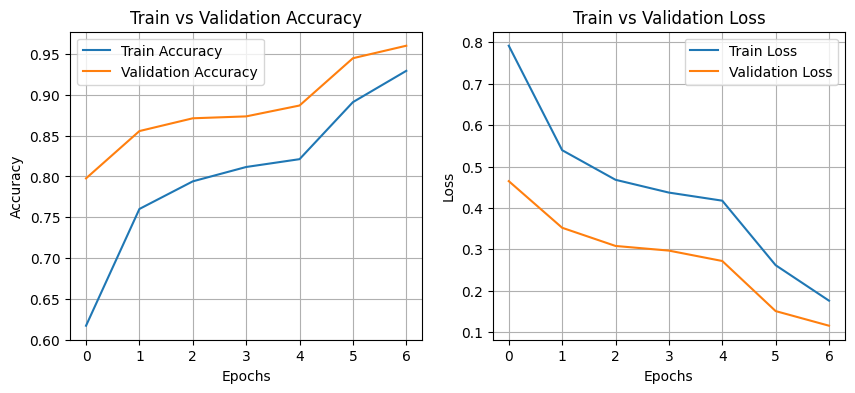

In [31]:
#compare the original training and fine-tuning performance
import matplotlib.pyplot as plt


def plot_fine_tuning(history, history_fine):
    # Combine accuracy
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

    # Combine loss
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    epochs_range = range(len(acc))

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid()

    plt.show()


# Call the function to plot
plot_fine_tuning(history, history_fine)

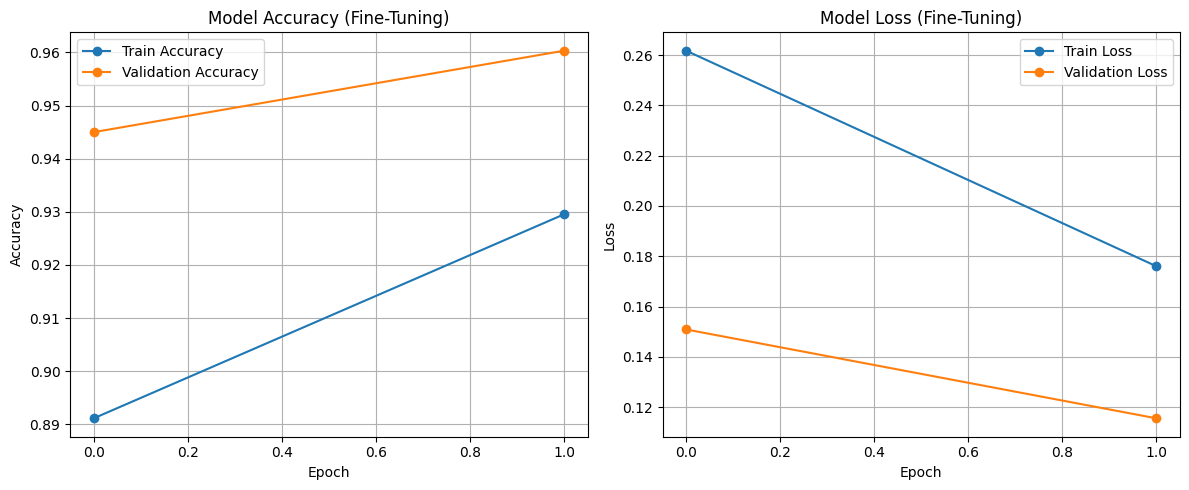

In [32]:
import matplotlib.pyplot as plt


def plot_history(history, title_suffix=""):
    # Create a figure with two subplots: one for accuracy, one for loss
    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy ' + title_suffix)
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], marker='o', label='Train Loss')
    plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss ' + title_suffix)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Plot the fine-tuning history
plot_history(history_fine, title_suffix="(Fine-Tuning)")


In [2]:

# Load and Predict a Single Image
test_image = image.load_img('D:/sdp/test/img_10.png', target_size=(150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0

result = model.predict(test_image)
class_index = np.argmax(result[0])
class_labels = {0: 'cat', 1: 'dog', 2: 'human'}
prediction = class_labels[class_index]

print(f"\n🟢 Prediction: {prediction}")

NameError: name 'model' is not defined

In [35]:
from keras.api.models import load_model
from keras_preprocessing.image import ImageDataGenerator

loaded_model = load_model('my_model-f.h5')

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    r'D:\sdp\redd\test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
loss, accuracy = loaded_model.evaluate(test_generator)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Loss: {loss:.4f}")

import numpy as np
from sklearn.metrics import classification_report

y_true = test_generator.classes

y_pred_probs = loaded_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

Found 3000 images belonging to 3 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 733ms/step - accuracy: 0.9220 - loss: 0.2369
Accuracy: 96.03%
Loss: 0.1155
94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 756ms/step
              precision    recall  f1-score   support

         cat       0.99      0.89      0.94      1000
         dog       0.90      0.99      0.95      1000
       human       1.00      1.00      1.00      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from PIL import ImageFile
from keras_preprocessing import image

ImageFile.LOAD_TRUNCATED_IMAGES = True

cnn = tf.keras.models.load_model('my_model-f.h5')

cap = cv2.VideoCapture(0)
cap.set(3, 640)  # Width
cap.set(4, 480)  # Height

while True:
    ret, frame = cap.read()

    cv2.imshow('Camera', frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('c'):
        # Process the captured image
        test_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        test_image_resized = cv2.resize(test_image, (150, 150))
        test_image_resized = image.img_to_array(test_image_resized)
        test_image_resized = np.expand_dims(test_image_resized, axis=0)
        test_image_resized = test_image_resized / 255.0

        result = cnn.predict(test_image_resized)
        class_index = np.argmax(result[0])
        class_labels = {0: 'cat', 1: 'dog', 2: 'human'}

        prediction = class_labels[class_index]
        print(f"Prediction: {prediction}")

        h, w, _ = frame.shape
        top_left = (50, 50)
        bottom_right = (w - 50, h - 50)

        cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
        label_position = (top_left[0], top_left[1] - 10)
        cv2.putText(frame, prediction, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        cv2.imshow('Camera with Bounding Box', frame)
        verbose=2

    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [16]:
import tensorflow as tf
import numpy as np
from keras_preprocessing import image

# Load Model
cnn = tf.keras.models.load_model('my_model-f.h5')

# Load and Preprocess Image
test_image = image.load_img('D:/sdp/test/processed_img2.png', target_size=(150, 150))
test_image = image.img_to_array(test_image)  # Convert to NumPy array
test_image = np.expand_dims(test_image, axis=0)  # Expand batch dimension
test_image = test_image / 255.0  # Normalize

# Predict
result = cnn.predict(test_image)
class_index = np.argmax(result[0])  # Get class index

# Define Class Labels
class_labels = {0: 'cat', 1: 'dog', 2: 'human'}
prediction = class_labels[class_index]

# Print Prediction
print(f"Prediction: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Prediction: dog
